### 3日数据：策略Part1+part3，前3天充0元的预测为0，不是0元的回归

In [132]:
import pandas as pd
import numpy as np
import random
import gc
import seaborn as sns
import lightgbm as lgb
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder,MinMaxScaler, StandardScaler
from sklearn.metrics import recall_score, auc, accuracy_score, f1_score, precision_score, classification_report, roc_auc_score,mean_squared_error
from pandas.api.types import is_categorical_dtype
from pandas.api.types import is_datetime64_any_dtype as is_datetime
import missingno as msno
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

In [133]:
data = pd.read_csv('./FE_data/data.csv')

In [134]:
data_train, data_test = train_test_split(data, test_size=0.3)

In [135]:
train_data_pay_3 = data_train[data_train['p2'] != 0]
train_data_nopay_3 = data_train[data_train['p2'] == 0]

In [136]:
target = train_data_pay_3['30d_pay_money']
features = train_data_pay_3.drop(['role_id','30d_pay_money','game_pay_num','chmoney_pay_num'], axis=1)
features.head()

,r1,r2,r3,r4,max_role_level,p1,p2,p3,p4,p5,p6,is_create_role,is_create_no,server_sum,platform,user_type,user_flag,mobile
1740512,25,1,6,2.90,62,11.0,600.0,0.0,0.0,11.0,596.6,1.0,1.0,1.0,1.0,2.0,1.0,1.0
200005,71,1,1,1.01,1,7.0,188.0,0.0,0.0,7.0,188.0,1.0,1.0,1.0,2.0,1.0,1.0,0.0
3759067,45,1,12,1.56,90,7.0,248.0,0.0,0.0,7.0,248.0,0.0,0.0,13.0,1.0,1.0,1.0,0.0
3079386,1,1,1,0.00,2,1.0,68.0,0.0,0.0,1.0,68.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0
4950549,7,1,3,10.12,0,1.0,30.0,0.0,0.0,1.0,30.0,1.0,0.0,1.0,1.0,44.0,1.0,0.0


In [137]:
target.value_counts()

12.0       17284
30.0        5610
42.0        5319
48.0        2172
60.0        1536
           ...  
31342.0        1
15382.0        1
17902.0        1
35800.0        1
2868.0         1
Name: 30d_pay_money, Length: 4382, dtype: int64

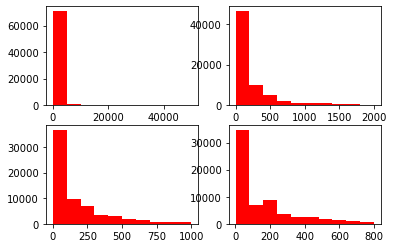

<Figure size 1600x800 with 0 Axes>

In [138]:
# 查看目标值的分布情况，大部分在4000以下
fig, axes = plt.subplots(2, 2)
ax1 = axes[0,0]
ax2 = axes[0,1]
ax3 = axes[1,0]
ax4 = axes[1,1]
fig = plt.figure(figsize=(20,10),dpi=80)
ax1.hist(target, color='red', range=(1, 50000))
ax2.hist(target, color='red', range=(1, 2000))
ax3.hist(target, color='red', range=(1, 1000))
ax4.hist(target, color='red', range=(1, 800))
plt.show()

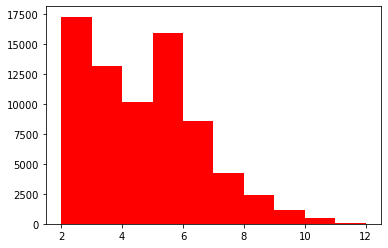

In [139]:
# 将target进行log1p转换，更符合正态分布
target_ln = np.log1p(target)
plt.hist(target_ln, color='red', range=(2, 12))
plt.show()

In [140]:
for col in features.columns:
    features[col] = np.log1p(features[col])
target_ln = np.log1p(target)

In [141]:
X_val, x_test, Y_val, y_test = train_test_split(features,target_ln, test_size=0.3)

In [142]:
params = {

"nthread":4,
"objective": "regression",
"boosting_type": "gbdt",
"learning_rate": 0.01,
"max_depth":7,
"num_leaves":5,
"max_bin":255,
"min_data_in_leaf":101,
"min_split_gain":1.0,
"feature_fraction": 1.0,
"bagging_fraction":0.6,
"bagging_freq":45,
"lambda_l1":1.0,
"lambda_l2":1.0,
"metric": "rmse",
}
train_data = lgb.Dataset(X_val, label=Y_val)
val_data = lgb.Dataset(x_test, label=y_test, reference=train_data)
lgb_r_cv = lgb.train(params, train_data, num_boost_round=8000, early_stopping_rounds=100, valid_sets=[train_data, val_data])

[1]	training's rmse: 1.79148	valid_1's rmse: 1.78914
Training until validation scores don't improve for 100 rounds
[2]	training's rmse: 1.77959	valid_1's rmse: 1.77728
[3]	training's rmse: 1.76785	valid_1's rmse: 1.76558
[4]	training's rmse: 1.75628	valid_1's rmse: 1.75403
[5]	training's rmse: 1.74486	valid_1's rmse: 1.74264
[6]	training's rmse: 1.73358	valid_1's rmse: 1.73139
[7]	training's rmse: 1.72247	valid_1's rmse: 1.7203
[8]	training's rmse: 1.71143	valid_1's rmse: 1.70931
[9]	training's rmse: 1.70061	valid_1's rmse: 1.69854
[10]	training's rmse: 1.68993	valid_1's rmse: 1.68791
[11]	training's rmse: 1.67931	valid_1's rmse: 1.67734
[12]	training's rmse: 1.66891	valid_1's rmse: 1.66699
[13]	training's rmse: 1.65866	valid_1's rmse: 1.65678
[14]	training's rmse: 1.64845	valid_1's rmse: 1.64661
[15]	training's rmse: 1.63843	valid_1's rmse: 1.63662
[16]	training's rmse: 1.62852	valid_1's rmse: 1.62672
[17]	training's rmse: 1.6188	valid_1's rmse: 1.61703
[18]	training's rmse: 1.60911	v

[151]	training's rmse: 1.04333	valid_1's rmse: 1.0434
[152]	training's rmse: 1.04207	valid_1's rmse: 1.04215
[153]	training's rmse: 1.04085	valid_1's rmse: 1.04093
[154]	training's rmse: 1.03964	valid_1's rmse: 1.03972
[155]	training's rmse: 1.03846	valid_1's rmse: 1.03856
[156]	training's rmse: 1.03726	valid_1's rmse: 1.03736
[157]	training's rmse: 1.03611	valid_1's rmse: 1.0362
[158]	training's rmse: 1.03499	valid_1's rmse: 1.03509
[159]	training's rmse: 1.03388	valid_1's rmse: 1.03398
[160]	training's rmse: 1.03277	valid_1's rmse: 1.03286
[161]	training's rmse: 1.0317	valid_1's rmse: 1.03179
[162]	training's rmse: 1.03065	valid_1's rmse: 1.03074
[163]	training's rmse: 1.02959	valid_1's rmse: 1.02969
[164]	training's rmse: 1.02856	valid_1's rmse: 1.02867
[165]	training's rmse: 1.02757	valid_1's rmse: 1.02768
[166]	training's rmse: 1.02656	valid_1's rmse: 1.02667
[167]	training's rmse: 1.02559	valid_1's rmse: 1.0257
[168]	training's rmse: 1.02464	valid_1's rmse: 1.02476
[169]	training

[298]	training's rmse: 0.966464	valid_1's rmse: 0.966892
[299]	training's rmse: 0.966273	valid_1's rmse: 0.966698
[300]	training's rmse: 0.966025	valid_1's rmse: 0.966474
[301]	training's rmse: 0.965802	valid_1's rmse: 0.966244
[302]	training's rmse: 0.965583	valid_1's rmse: 0.966036
[303]	training's rmse: 0.965364	valid_1's rmse: 0.965811
[304]	training's rmse: 0.965129	valid_1's rmse: 0.965596
[305]	training's rmse: 0.964951	valid_1's rmse: 0.965416
[306]	training's rmse: 0.964719	valid_1's rmse: 0.965208
[307]	training's rmse: 0.96453	valid_1's rmse: 0.965018
[308]	training's rmse: 0.964324	valid_1's rmse: 0.964806
[309]	training's rmse: 0.9641	valid_1's rmse: 0.964605
[310]	training's rmse: 0.963918	valid_1's rmse: 0.964422
[311]	training's rmse: 0.963732	valid_1's rmse: 0.964228
[312]	training's rmse: 0.963535	valid_1's rmse: 0.964025
[313]	training's rmse: 0.963319	valid_1's rmse: 0.963832
[314]	training's rmse: 0.963128	valid_1's rmse: 0.963635
[315]	training's rmse: 0.962919	va

[451]	training's rmse: 0.947396	valid_1's rmse: 0.94826
[452]	training's rmse: 0.947296	valid_1's rmse: 0.948158
[453]	training's rmse: 0.9472	valid_1's rmse: 0.948061
[454]	training's rmse: 0.947104	valid_1's rmse: 0.94796
[455]	training's rmse: 0.947009	valid_1's rmse: 0.947861
[456]	training's rmse: 0.946919	valid_1's rmse: 0.947769
[457]	training's rmse: 0.946828	valid_1's rmse: 0.947674
[458]	training's rmse: 0.946741	valid_1's rmse: 0.947585
[459]	training's rmse: 0.946657	valid_1's rmse: 0.947485
[460]	training's rmse: 0.946575	valid_1's rmse: 0.947388
[461]	training's rmse: 0.946514	valid_1's rmse: 0.947323
[462]	training's rmse: 0.946455	valid_1's rmse: 0.94726
[463]	training's rmse: 0.946371	valid_1's rmse: 0.947172
[464]	training's rmse: 0.9463	valid_1's rmse: 0.947095
[465]	training's rmse: 0.946244	valid_1's rmse: 0.947035
[466]	training's rmse: 0.946188	valid_1's rmse: 0.946975
[467]	training's rmse: 0.94612	valid_1's rmse: 0.946902
[468]	training's rmse: 0.946066	valid_1

[622]	training's rmse: 0.939199	valid_1's rmse: 0.939891
[623]	training's rmse: 0.939168	valid_1's rmse: 0.93986
[624]	training's rmse: 0.939135	valid_1's rmse: 0.939827
[625]	training's rmse: 0.93911	valid_1's rmse: 0.939805
[626]	training's rmse: 0.939076	valid_1's rmse: 0.939782
[627]	training's rmse: 0.939053	valid_1's rmse: 0.939758
[628]	training's rmse: 0.939027	valid_1's rmse: 0.93972
[629]	training's rmse: 0.939002	valid_1's rmse: 0.939699
[630]	training's rmse: 0.938975	valid_1's rmse: 0.939674
[631]	training's rmse: 0.938947	valid_1's rmse: 0.93965
[632]	training's rmse: 0.938921	valid_1's rmse: 0.939627
[633]	training's rmse: 0.938896	valid_1's rmse: 0.939603
[634]	training's rmse: 0.93887	valid_1's rmse: 0.939581
[635]	training's rmse: 0.938846	valid_1's rmse: 0.939559
[636]	training's rmse: 0.938821	valid_1's rmse: 0.939537
[637]	training's rmse: 0.938798	valid_1's rmse: 0.939516
[638]	training's rmse: 0.938775	valid_1's rmse: 0.939496
[639]	training's rmse: 0.938743	vali

[790]	training's rmse: 0.935581	valid_1's rmse: 0.936823
[791]	training's rmse: 0.935557	valid_1's rmse: 0.936804
[792]	training's rmse: 0.935532	valid_1's rmse: 0.936783
[793]	training's rmse: 0.935517	valid_1's rmse: 0.936775
[794]	training's rmse: 0.935494	valid_1's rmse: 0.936757
[795]	training's rmse: 0.935469	valid_1's rmse: 0.936737
[796]	training's rmse: 0.935461	valid_1's rmse: 0.936731
[797]	training's rmse: 0.93545	valid_1's rmse: 0.936725
[798]	training's rmse: 0.935426	valid_1's rmse: 0.936705
[799]	training's rmse: 0.935404	valid_1's rmse: 0.936687
[800]	training's rmse: 0.935389	valid_1's rmse: 0.93668
[801]	training's rmse: 0.935382	valid_1's rmse: 0.936675
[802]	training's rmse: 0.935358	valid_1's rmse: 0.936655
[803]	training's rmse: 0.935339	valid_1's rmse: 0.936635
[804]	training's rmse: 0.935325	valid_1's rmse: 0.936628
[805]	training's rmse: 0.935302	valid_1's rmse: 0.936609
[806]	training's rmse: 0.935276	valid_1's rmse: 0.936589
[807]	training's rmse: 0.935269	v

[972]	training's rmse: 0.933271	valid_1's rmse: 0.934713
[973]	training's rmse: 0.933263	valid_1's rmse: 0.934708
[974]	training's rmse: 0.933258	valid_1's rmse: 0.934704
[975]	training's rmse: 0.933244	valid_1's rmse: 0.934692
[976]	training's rmse: 0.933239	valid_1's rmse: 0.934689
[977]	training's rmse: 0.933225	valid_1's rmse: 0.934676
[978]	training's rmse: 0.933221	valid_1's rmse: 0.934673
[979]	training's rmse: 0.933215	valid_1's rmse: 0.93467
[980]	training's rmse: 0.933203	valid_1's rmse: 0.934664
[981]	training's rmse: 0.933189	valid_1's rmse: 0.934652
[982]	training's rmse: 0.933178	valid_1's rmse: 0.934647
[983]	training's rmse: 0.933173	valid_1's rmse: 0.934644
[984]	training's rmse: 0.933156	valid_1's rmse: 0.934631
[985]	training's rmse: 0.933151	valid_1's rmse: 0.934628
[986]	training's rmse: 0.93314	valid_1's rmse: 0.934619
[987]	training's rmse: 0.933135	valid_1's rmse: 0.934616
[988]	training's rmse: 0.933128	valid_1's rmse: 0.93461
[989]	training's rmse: 0.933116	va

[1131]	training's rmse: 0.931823	valid_1's rmse: 0.933697
[1132]	training's rmse: 0.931815	valid_1's rmse: 0.933694
[1133]	training's rmse: 0.931807	valid_1's rmse: 0.93369
[1134]	training's rmse: 0.931799	valid_1's rmse: 0.933688
[1135]	training's rmse: 0.931791	valid_1's rmse: 0.933685
[1136]	training's rmse: 0.931783	valid_1's rmse: 0.933682
[1137]	training's rmse: 0.931768	valid_1's rmse: 0.933674
[1138]	training's rmse: 0.931754	valid_1's rmse: 0.933667
[1139]	training's rmse: 0.931747	valid_1's rmse: 0.933664
[1140]	training's rmse: 0.931738	valid_1's rmse: 0.933661
[1141]	training's rmse: 0.931731	valid_1's rmse: 0.933658
[1142]	training's rmse: 0.931723	valid_1's rmse: 0.933655
[1143]	training's rmse: 0.931716	valid_1's rmse: 0.933653
[1144]	training's rmse: 0.931708	valid_1's rmse: 0.93365
[1145]	training's rmse: 0.931701	valid_1's rmse: 0.933648
[1146]	training's rmse: 0.931693	valid_1's rmse: 0.933645
[1147]	training's rmse: 0.931686	valid_1's rmse: 0.933643
[1148]	training'

[1306]	training's rmse: 0.930473	valid_1's rmse: 0.932733
[1307]	training's rmse: 0.930463	valid_1's rmse: 0.932727
[1308]	training's rmse: 0.930455	valid_1's rmse: 0.932721
[1309]	training's rmse: 0.930445	valid_1's rmse: 0.932713
[1310]	training's rmse: 0.930436	valid_1's rmse: 0.932705
[1311]	training's rmse: 0.930426	valid_1's rmse: 0.932699
[1312]	training's rmse: 0.930417	valid_1's rmse: 0.932691
[1313]	training's rmse: 0.930409	valid_1's rmse: 0.932686
[1314]	training's rmse: 0.930404	valid_1's rmse: 0.932683
[1315]	training's rmse: 0.930399	valid_1's rmse: 0.93268
[1316]	training's rmse: 0.930394	valid_1's rmse: 0.932677
[1317]	training's rmse: 0.930389	valid_1's rmse: 0.932675
[1318]	training's rmse: 0.930384	valid_1's rmse: 0.932672
[1319]	training's rmse: 0.93038	valid_1's rmse: 0.93267
[1320]	training's rmse: 0.930375	valid_1's rmse: 0.932669
[1321]	training's rmse: 0.930366	valid_1's rmse: 0.932664
[1322]	training's rmse: 0.930363	valid_1's rmse: 0.932665
[1323]	training's

[1501]	training's rmse: 0.929401	valid_1's rmse: 0.932059
[1502]	training's rmse: 0.929396	valid_1's rmse: 0.932057
[1503]	training's rmse: 0.929387	valid_1's rmse: 0.93205
[1504]	training's rmse: 0.929381	valid_1's rmse: 0.932047
[1505]	training's rmse: 0.929375	valid_1's rmse: 0.932045
[1506]	training's rmse: 0.92937	valid_1's rmse: 0.932043
[1507]	training's rmse: 0.929361	valid_1's rmse: 0.932036
[1508]	training's rmse: 0.929356	valid_1's rmse: 0.932034
[1509]	training's rmse: 0.929351	valid_1's rmse: 0.932031
[1510]	training's rmse: 0.929343	valid_1's rmse: 0.932025
[1511]	training's rmse: 0.929338	valid_1's rmse: 0.932023
[1512]	training's rmse: 0.929332	valid_1's rmse: 0.932017
[1513]	training's rmse: 0.929327	valid_1's rmse: 0.932015
[1514]	training's rmse: 0.929319	valid_1's rmse: 0.932009
[1515]	training's rmse: 0.929314	valid_1's rmse: 0.932005
[1516]	training's rmse: 0.929309	valid_1's rmse: 0.932003
[1517]	training's rmse: 0.929304	valid_1's rmse: 0.931997
[1518]	training'

[1681]	training's rmse: 0.92863	valid_1's rmse: 0.931655
[1682]	training's rmse: 0.928625	valid_1's rmse: 0.931654
[1683]	training's rmse: 0.92862	valid_1's rmse: 0.931652
[1684]	training's rmse: 0.928616	valid_1's rmse: 0.93165
[1685]	training's rmse: 0.928611	valid_1's rmse: 0.931649
[1686]	training's rmse: 0.928606	valid_1's rmse: 0.931649
[1687]	training's rmse: 0.9286	valid_1's rmse: 0.931642
[1688]	training's rmse: 0.928595	valid_1's rmse: 0.931642
[1689]	training's rmse: 0.92859	valid_1's rmse: 0.931641
[1690]	training's rmse: 0.928586	valid_1's rmse: 0.931641
[1691]	training's rmse: 0.92858	valid_1's rmse: 0.931634
[1692]	training's rmse: 0.928575	valid_1's rmse: 0.931634
[1693]	training's rmse: 0.928571	valid_1's rmse: 0.931633
[1694]	training's rmse: 0.928567	valid_1's rmse: 0.931632
[1695]	training's rmse: 0.928563	valid_1's rmse: 0.931632
[1696]	training's rmse: 0.928557	valid_1's rmse: 0.931626
[1697]	training's rmse: 0.928552	valid_1's rmse: 0.931626
[1698]	training's rms

[1879]	training's rmse: 0.927832	valid_1's rmse: 0.931392
[1880]	training's rmse: 0.927827	valid_1's rmse: 0.93139
[1881]	training's rmse: 0.927823	valid_1's rmse: 0.93139
[1882]	training's rmse: 0.927818	valid_1's rmse: 0.931386
[1883]	training's rmse: 0.927814	valid_1's rmse: 0.931386
[1884]	training's rmse: 0.92781	valid_1's rmse: 0.931384
[1885]	training's rmse: 0.927807	valid_1's rmse: 0.931384
[1886]	training's rmse: 0.927804	valid_1's rmse: 0.931384
[1887]	training's rmse: 0.927799	valid_1's rmse: 0.93138
[1888]	training's rmse: 0.927796	valid_1's rmse: 0.931379
[1889]	training's rmse: 0.927791	valid_1's rmse: 0.931377
[1890]	training's rmse: 0.927788	valid_1's rmse: 0.931377
[1891]	training's rmse: 0.927785	valid_1's rmse: 0.931374
[1892]	training's rmse: 0.927781	valid_1's rmse: 0.93137
[1893]	training's rmse: 0.927778	valid_1's rmse: 0.931367
[1894]	training's rmse: 0.927775	valid_1's rmse: 0.931361
[1895]	training's rmse: 0.927771	valid_1's rmse: 0.931358
[1896]	training's r

[2074]	training's rmse: 0.92713	valid_1's rmse: 0.930941
[2075]	training's rmse: 0.927127	valid_1's rmse: 0.930938
[2076]	training's rmse: 0.927123	valid_1's rmse: 0.930936
[2077]	training's rmse: 0.92712	valid_1's rmse: 0.930934
[2078]	training's rmse: 0.927112	valid_1's rmse: 0.930932
[2079]	training's rmse: 0.927109	valid_1's rmse: 0.93093
[2080]	training's rmse: 0.927105	valid_1's rmse: 0.930928
[2081]	training's rmse: 0.927101	valid_1's rmse: 0.930926
[2082]	training's rmse: 0.927095	valid_1's rmse: 0.930924
[2083]	training's rmse: 0.927091	valid_1's rmse: 0.930922
[2084]	training's rmse: 0.927088	valid_1's rmse: 0.93092
[2085]	training's rmse: 0.927086	valid_1's rmse: 0.93092
[2086]	training's rmse: 0.927084	valid_1's rmse: 0.93092
[2087]	training's rmse: 0.92708	valid_1's rmse: 0.930918
[2088]	training's rmse: 0.927078	valid_1's rmse: 0.930918
[2089]	training's rmse: 0.927075	valid_1's rmse: 0.930916
[2090]	training's rmse: 0.927073	valid_1's rmse: 0.930916
[2091]	training's rms

[2274]	training's rmse: 0.926688	valid_1's rmse: 0.930799
[2275]	training's rmse: 0.926686	valid_1's rmse: 0.930801
[2276]	training's rmse: 0.926685	valid_1's rmse: 0.930802
[2277]	training's rmse: 0.926683	valid_1's rmse: 0.930804
[2278]	training's rmse: 0.926679	valid_1's rmse: 0.930796
[2279]	training's rmse: 0.926678	valid_1's rmse: 0.930797
[2280]	training's rmse: 0.926675	valid_1's rmse: 0.930799
[2281]	training's rmse: 0.926675	valid_1's rmse: 0.9308
[2282]	training's rmse: 0.926671	valid_1's rmse: 0.930793
[2283]	training's rmse: 0.926669	valid_1's rmse: 0.930795
[2284]	training's rmse: 0.926668	valid_1's rmse: 0.930796
[2285]	training's rmse: 0.926667	valid_1's rmse: 0.930798
[2286]	training's rmse: 0.926663	valid_1's rmse: 0.93079
[2287]	training's rmse: 0.926661	valid_1's rmse: 0.930792
[2288]	training's rmse: 0.926658	valid_1's rmse: 0.930792
[2289]	training's rmse: 0.926656	valid_1's rmse: 0.930794
[2290]	training's rmse: 0.926653	valid_1's rmse: 0.930795
[2291]	training's

In [143]:
y_predict = lgb_r_cv.predict(x_test)
mse = mean_squared_error(np.expm1(y_predict), np.expm1(y_test))
mae = mean_absolute_error(np.expm1(y_predict), np.expm1(y_test))
rmse = mse ** 0.5
print(rmse)
print(mse)
print(mae)

2862.7984547459296
8195614.992495683
563.1409570624257


# 用data_test 测试

In [144]:
# 把前3天没有付费的角色提出来，直接预测前30天不会付费
data_test_nopay_3 = data_test[data_test['p2'] == 0]
data_test_part1 = data_test_nopay_3[['role_id', 'p2']].rename(columns={'p2':'predict_30_pay'})

In [150]:
# 提取前3天付费，进行回归预测
data_test_pay_3 = data_test[data_test['p2'] != 0]
features_data_test_pay_3 = data_test_pay_3.drop(['role_id', 'game_pay_num', 'chmoney_pay_num', 
                                                 '30d_pay_money'], axis=1)
for col in features_data_test_pay_3.columns:
    features_data_test_pay_3[col] = np.log1p(features_data_test_pay_3[col])
y_predict = np.expm1(lgb_r_cv.predict(features_data_test_pay_3))

In [152]:
y_predict = np.where(y_predict<0,0,y_predict)

p2 = data_test_pay_3['p2'].values
for i in range(len(data_test_pay_3)):
    if p2[i]>y_predict[i]:
        y_predict[i] = p2[i]

mse = mean_squared_error(y_predict, data_test_pay_3['30d_pay_money'])
mae = mean_absolute_error(y_predict, data_test_pay_3['30d_pay_money'])
rmse = mse ** 0.5
print(rmse)
print(mse)
print(mae)

2857.9505805865683
8167881.521075103
550.1819474629414


In [153]:
data_test_pay_3['predict_30_pay'] = y_predict
data_test_part3 = data_test_pay_3[['role_id', 'predict_30_pay']]

C:\Users\Administrator\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [154]:
data_test_part3['predict_30_pay'].sort_values()

3591454       12.000000
367141        12.000000
2537022       12.000000
3432430       12.000000
2975738       12.000000
               ...     
4115672    34581.406315
2752713    34927.259589
2971464    37342.507930
4833181    42467.988129
2245097    54324.000000
Name: predict_30_pay, Length: 31220, dtype: float64

In [155]:
pred = data_test_part1.append(data_test_part3)
print(pred.shape)

(1549330, 2)


In [166]:
predict_data = pd.merge(data_test[['role_id', '30d_pay_money']],pred,on='role_id',how='left',validate='one_to_one')
predict_data.sort_values('predict_30_pay', ascending=False).head(50)

,role_id,30d_pay_money,predict_30_pay
173553,136776599,97666.0,54324.000000
349332,142745933,36024.0,42467.988129
1544130,12180340,20586.0,37342.507930
1545792,140559952,49408.0,34927.259589
933192,144811796,34512.0,34581.406315
970941,135175071,11434.0,31929.399901
1247421,12260525,74078.0,31752.730139
844771,12101247,50768.0,31585.033150
1482786,13582238,9610.0,31531.213843
1346239,13127118,13822.0,31513.077577


In [167]:
predict_data.sort_values('predict_30_pay').head(50)

,role_id,30d_pay_money,predict_30_pay
0,11932341,0.0,0.0
1027652,146208513,0.0,0.0
1027651,142436124,0.0,0.0
1027650,144724622,0.0,0.0
1027649,145497853,0.0,0.0
1027648,148649433,0.0,0.0
1027647,11809548,0.0,0.0
1027646,143821012,0.0,0.0
1027645,11494824,0.0,0.0
1027644,148507591,0.0,0.0


In [168]:
mse = mean_squared_error(predict_data['predict_30_pay'], predict_data['30d_pay_money'])
mae = mean_absolute_error(predict_data['predict_30_pay'], predict_data['30d_pay_money'])
rmse = mse ** 0.5
print('测试集上的均方根误差:%.2f元'% rmse)
# print('测试集上的均方误差:%f元' % mse)
print('测试集上的平均绝对误差:%.2f元'% mae)

测试集上的均方根误差:413.68元
测试集上的平均绝对误差:12.11元


In [169]:
data_train['30d_pay_money'].describe()

count    3.615101e+06
mean     1.868104e+01
std      5.779514e+02
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.567880e+05
Name: 30d_pay_money, dtype: float64

In [170]:
predict_data['predict_30_pay'].describe()

count    1.549330e+06
mean     1.103641e+01
std      2.975040e+02
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      5.432400e+04
Name: predict_30_pay, dtype: float64

In [171]:
1.868/1.1036

1.692642261689018

In [172]:
predict_data['predict_30_pay'] = predict_data['predict_30_pay']*1.69

In [173]:
mse = mean_squared_error(predict_data['predict_30_pay'], predict_data['30d_pay_money'])
mae = mean_absolute_error(predict_data['predict_30_pay'], predict_data['30d_pay_money'])
rmse = mse ** 0.5
print('测试集上的均方根误差:%.2f元'% rmse)
# print('测试集上的均方误差:%f元' % mse)
print('测试集上的平均绝对误差:%.2f元'% mae)

测试集上的均方根误差:406.39元
测试集上的平均绝对误差:14.73元


In [174]:
print('测试集前30天实际总的付费金额:%.2f元' % predict_data['30d_pay_money'].sum())
print('测试集前30天预测总的付费金额:%.2f元'% predict_data['predict_30_pay'].sum())
print('预测总金额准确率:',predict_data['predict_30_pay'].sum()/predict_data['30d_pay_money'].sum())

测试集前30天实际总的付费金额:28327749.00元
测试集前30天预测总的付费金额:28897368.02元
预测总金额准确率: 1.0201081637335825


In [175]:
data_big_R = predict_data[predict_data['30d_pay_money'] >=2000]
predict_big_R = predict_data[predict_data['predict_30_pay'] >=2000]

In [176]:
print(data_big_R.shape)
print(predict_big_R.shape)
print(len(np.intersect1d(data_big_R['role_id'], predict_big_R['role_id'])))
print('大R预测准确率:%.4f'%(len(np.intersect1d(data_big_R['role_id'], predict_big_R['role_id']))/data_big_R.shape[0]))

(2356, 3)
(2466, 3)
1509
大R预测准确率:0.6405


In [177]:
data_test[data_test['p2'] >=2000].shape

(702, 22)